In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as tp
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.config("spark.sql.shuffle.partitions", "200").config("spark.executor.memory", "4g").config("master", "yarn").getOrCreate()

In [3]:
spark

In [4]:
train = spark.read.csv("dataset/ml_project/train.csv",header = True, inferSchema = True)
test = spark.read.csv("dataset/ml_project/test.csv",header = True, inferSchema = True)
valid = spark.read.csv("dataset/ml_project/valid.csv",header = True, inferSchema = True)

## Varibale Identification - numeric/categorical/temporal/boolean

In [5]:
train.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- Carrier: double (nullable = true)
 |-- TrafficType: string (nullable = true)
 |-- ClickDate: string (nullable = true)
 |-- Device: string (nullable = true)
 |-- Browser: string (nullable = true)
 |-- OS: string (nullable = true)
 |-- ConversionStatus: boolean (nullable = true)
 |-- publisherId: string (nullable = true)
 |-- advertiserCampaignId: double (nullable = true)
 |-- Fraud: double (nullable = true)



* carrier is double but type of category
* PublisherId is also categorical in nature

# Univariate Analysis balanced / imbalanced dataset

In [6]:
# for value_counts use groupby and count function
train.groupBy(F.col("ConversionStatus")).agg(F.count("ConversionStatus").alias("no of status"), (F.count("ConversionStatus")/train.count()).alias("percentage"))

ConversionStatus,no of status,percentage
null,0,0.0
true,550,6.055801457796569E-4
false,907669,0.9993933187994098


### Type casting target variable in test, train and validation data

In [7]:
train = train.withColumn("ConversionStatus",F.col("ConversionStatus").cast(tp.IntegerType()))
test = test.withColumn("ConversionStatus",F.col("ConversionStatus").cast(tp.IntegerType()))
valid = valid.withColumn("ConversionStatus",F.col("ConversionStatus").cast(tp.IntegerType()))

### Count the number of missing values in each column

In [8]:
for column in train.columns:
    null_condition = F.isnull(column)
    nulls_count = train.filter(null_condition).count()
    print(f"Column : {column}  Nulls count:{nulls_count}")

Column : ID  Nulls count:0
Column : Country  Nulls count:4889
Column : Carrier  Nulls count:0
Column : TrafficType  Nulls count:130051
Column : ClickDate  Nulls count:0
Column : Device  Nulls count:1197
Column : Browser  Nulls count:3256
Column : OS  Nulls count:3087
Column : ConversionStatus  Nulls count:1
Column : publisherId  Nulls count:1
Column : advertiserCampaignId  Nulls count:5
Column : Fraud  Nulls count:1


### Distict values in each column

In [9]:
train.agg(*[F.countDistinct(F.col(column)).alias(column) for column in train.columns])

ID,Country,Carrier,TrafficType,ClickDate,Device,Browser,OS,ConversionStatus,publisherId,advertiserCampaignId,Fraud
908220,189,284,2,28251,694,28,15,2,1841,485,2


### Hence TrafficType, publisherId are also cateorical

In [10]:
country_list = train.groupBy("Country").agg(F.count("Country").alias("count")).orderBy("count", ascending = False).limit(20)

In [11]:
top_20_countries = country_list.select("Country").collect()

In [12]:
top_20_countries

[Row(Country='IN'),
 Row(Country='TH'),
 Row(Country='ID'),
 Row(Country='BD'),
 Row(Country='MX'),
 Row(Country='BR'),
 Row(Country='RU'),
 Row(Country='NG'),
 Row(Country='MY'),
 Row(Country='US'),
 Row(Country='BO'),
 Row(Country='PH'),
 Row(Country='ZA'),
 Row(Country='VE'),
 Row(Country='GT'),
 Row(Country='DZ'),
 Row(Country='KR'),
 Row(Country='CO'),
 Row(Country='IQ'),
 Row(Country='AE')]

In [13]:
top_20_countries = [row.Country for row in top_20_countries]

In [14]:
top_20_countries

['IN',
 'TH',
 'ID',
 'BD',
 'MX',
 'BR',
 'RU',
 'NG',
 'MY',
 'US',
 'BO',
 'PH',
 'ZA',
 'VE',
 'GT',
 'DZ',
 'KR',
 'CO',
 'IQ',
 'AE']

In [15]:
def map_countries(country):
    if country in top_20_countries:
        return country
    else:
        return "Others"
udf_map_countries = F.udf(f = map_countries, returnType = tp.StringType())

In [16]:
train = train.withColumn("Country_code", udf_map_countries(train["Country"]))
test = test.withColumn("Country_code", udf_map_countries(test["Country"]))
valid = valid.withColumn("Country_code", udf_map_countries(valid["Country"]))

In [17]:
train_country = train.withColumn("Country_code", udf_map_countries(train["Country"]))

In [18]:
train_country = train_country.groupBy("Country_code").agg(F.count("Country_code")).orderBy("Country_code", ascending = False)

In [19]:
top_20_countries_df = train_country.toPandas()
top_20_countries_df.head()

,Country_code,count(Country_code)
0,ZA,10410
1,VE,10049
2,US,17020
3,TH,148669
4,RU,26780


<BarContainer object of 21 artists>

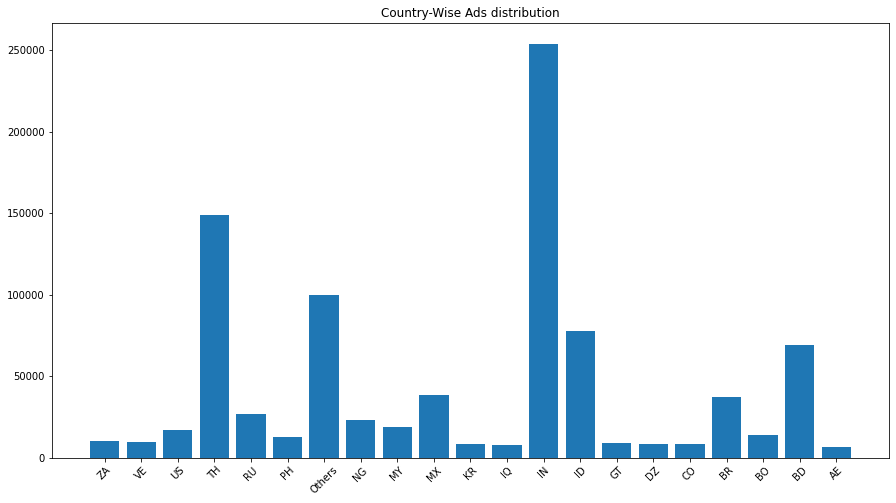

In [20]:
plt.figure(figsize = (15,8))
plt.title("Country-Wise Ads distribution")
plt.xticks(rotation = 45)
plt.bar(top_20_countries_df["Country_code"], top_20_countries_df["count(Country_code)"])

# Value_counts for TrafficType, Fraud, Device(convert to Generic-1 and Non-Generic-0)
### Apply same transformations for test and valid

In [21]:
train.groupBy("TrafficType").agg(F.count("TrafficType").alias("count")).orderBy("count", ascending = False)

Py4JJavaError: An error occurred while calling o336.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: ResultStage 66 (showString at NativeMethodAccessorImpl.java:0) has failed the maximum allowable number of times: 4. Most recent failure reason: org.apache.spark.shuffle.FetchFailedException: java.lang.IllegalArgumentException: Unknown message type: 9 	at org.apache.spark.network.shuffle.protocol.BlockTransferMessage$Decoder.fromByteBuffer(BlockTransferMessage.java:71) 	at org.apache.spark.network.shuffle.ExternalShuffleBlockHandler.receive(ExternalShuffleBlockHandler.java:80) 	at org.apache.spark.network.server.TransportRequestHandler.processRpcRequest(TransportRequestHandler.java:180) 	at org.apache.spark.network.server.TransportRequestHandler.handle(TransportRequestHandler.java:103) 	at org.apache.spark.network.server.TransportChannelHandler.channelRead(TransportChannelHandler.java:118) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.handler.timeout.IdleStateHandler.channelRead(IdleStateHandler.java:286) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.handler.codec.MessageToMessageDecoder.channelRead(MessageToMessageDecoder.java:102) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.apache.spark.network.util.TransportFrameDecoder.channelRead(TransportFrameDecoder.java:85) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.channel.DefaultChannelPipeline$HeadContext.channelRead(DefaultChannelPipeline.java:1410) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.DefaultChannelPipeline.fireChannelRead(DefaultChannelPipeline.java:919) 	at org.spark_project.io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:163) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:714) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:650) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:576) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:493) 	at org.spark_project.io.netty.util.concurrent.SingleThreadEventExecutor$4.run(SingleThreadEventExecutor.java:989) 	at org.spark_project.io.netty.util.internal.ThreadExecutorMap$2.run(ThreadExecutorMap.java:74) 	at org.spark_project.io.netty.util.concurrent.FastThreadLocalRunnable.run(FastThreadLocalRunnable.java:30) 	at java.lang.Thread.run(Thread.java:748)  	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:770) 	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:685) 	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:70) 	at org.apache.spark.util.CompletionIterator.next(CompletionIterator.scala:29) 	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:484) 	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:490) 	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458) 	at org.apache.spark.util.CompletionIterator.hasNext(CompletionIterator.scala:31) 	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37) 	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458) 	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.agg_doAggregateWithKeys_0$(Unknown Source) 	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source) 	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43) 	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755) 	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458) 	at scala.collection.convert.Wrappers$IteratorWrapper.hasNext(Wrappers.scala:31) 	at org.sparkproject.guava.collect.Ordering.leastOf(Ordering.java:628) 	at org.apache.spark.util.collection.Utils$.takeOrdered(Utils.scala:37) 	at org.apache.spark.rdd.RDD.$anonfun$takeOrdered$2(RDD.scala:1518) 	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863) 	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863) 	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52) 	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373) 	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337) 	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90) 	at org.apache.spark.scheduler.Task.run(Task.scala:131) 	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497) 	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439) 	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500) 	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149) 	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624) 	at java.lang.Thread.run(Thread.java:748) Caused by: java.lang.RuntimeException: java.lang.IllegalArgumentException: Unknown message type: 9 	at org.apache.spark.network.shuffle.protocol.BlockTransferMessage$Decoder.fromByteBuffer(BlockTransferMessage.java:71) 	at org.apache.spark.network.shuffle.ExternalShuffleBlockHandler.receive(ExternalShuffleBlockHandler.java:80) 	at org.apache.spark.network.server.TransportRequestHandler.processRpcRequest(TransportRequestHandler.java:180) 	at org.apache.spark.network.server.TransportRequestHandler.handle(TransportRequestHandler.java:103) 	at org.apache.spark.network.server.TransportChannelHandler.channelRead(TransportChannelHandler.java:118) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.handler.timeout.IdleStateHandler.channelRead(IdleStateHandler.java:286) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.handler.codec.MessageToMessageDecoder.channelRead(MessageToMessageDecoder.java:102) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.apache.spark.network.util.TransportFrameDecoder.channelRead(TransportFrameDecoder.java:85) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.channel.DefaultChannelPipeline$HeadContext.channelRead(DefaultChannelPipeline.java:1410) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.DefaultChannelPipeline.fireChannelRead(DefaultChannelPipeline.java:919) 	at org.spark_project.io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:163) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:714) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:650) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:576) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:493) 	at org.spark_project.io.netty.util.concurrent.SingleThreadEventExecutor$4.run(SingleThreadEventExecutor.java:989) 	at org.spark_project.io.netty.util.internal.ThreadExecutorMap$2.run(ThreadExecutorMap.java:74) 	at org.spark_project.io.netty.util.concurrent.FastThreadLocalRunnable.run(FastThreadLocalRunnable.java:30) 	at java.lang.Thread.run(Thread.java:748)  	at org.apache.spark.network.client.TransportResponseHandler.handle(TransportResponseHandler.java:208) 	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:142) 	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:53) 	at io.netty.channel.SimpleChannelInboundHandler.channelRead(SimpleChannelInboundHandler.java:99) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at io.netty.handler.timeout.IdleStateHandler.channelRead(IdleStateHandler.java:286) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at io.netty.handler.codec.MessageToMessageDecoder.channelRead(MessageToMessageDecoder.java:103) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.apache.spark.network.util.TransportFrameDecoder.channelRead(TransportFrameDecoder.java:102) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at io.netty.channel.DefaultChannelPipeline$HeadContext.channelRead(DefaultChannelPipeline.java:1410) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.DefaultChannelPipeline.fireChannelRead(DefaultChannelPipeline.java:919) 	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:163) 	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:714) 	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:650) 	at io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:576) 	at io.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:493) 	at io.netty.util.concurrent.SingleThreadEventExecutor$4.run(SingleThreadEventExecutor.java:989) 	at io.netty.util.internal.ThreadExecutorMap$2.run(ThreadExecutorMap.java:74) 	at io.netty.util.concurrent.FastThreadLocalRunnable.run(FastThreadLocalRunnable.java:30) 	... 1 more 
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskCompletion(DAGScheduler.scala:1768)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2442)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2291)
	at org.apache.spark.rdd.RDD.$anonfun$reduce$1(RDD.scala:1120)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.reduce(RDD.scala:1102)
	at org.apache.spark.rdd.RDD.$anonfun$takeOrdered$1(RDD.scala:1524)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.takeOrdered(RDD.scala:1512)
	at org.apache.spark.sql.execution.TakeOrderedAndProjectExec.executeCollect(limit.scala:187)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3696)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2929)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:301)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:338)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)


TrafficType,count
A,537466
M,240703
null,0


In [22]:
train.groupBy("Fraud").agg(F.count("Fraud").alias("count")).orderBy("count", ascending = False)

Py4JJavaError: An error occurred while calling o366.getRowsToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: ResultStage 72 (getRowsToPython at NativeMethodAccessorImpl.java:0) has failed the maximum allowable number of times: 4. Most recent failure reason: org.apache.spark.shuffle.FetchFailedException: java.lang.IllegalArgumentException: Unknown message type: 9 	at org.apache.spark.network.shuffle.protocol.BlockTransferMessage$Decoder.fromByteBuffer(BlockTransferMessage.java:71) 	at org.apache.spark.network.shuffle.ExternalShuffleBlockHandler.receive(ExternalShuffleBlockHandler.java:80) 	at org.apache.spark.network.server.TransportRequestHandler.processRpcRequest(TransportRequestHandler.java:180) 	at org.apache.spark.network.server.TransportRequestHandler.handle(TransportRequestHandler.java:103) 	at org.apache.spark.network.server.TransportChannelHandler.channelRead(TransportChannelHandler.java:118) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.handler.timeout.IdleStateHandler.channelRead(IdleStateHandler.java:286) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.handler.codec.MessageToMessageDecoder.channelRead(MessageToMessageDecoder.java:102) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.apache.spark.network.util.TransportFrameDecoder.channelRead(TransportFrameDecoder.java:85) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.channel.DefaultChannelPipeline$HeadContext.channelRead(DefaultChannelPipeline.java:1410) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.DefaultChannelPipeline.fireChannelRead(DefaultChannelPipeline.java:919) 	at org.spark_project.io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:163) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:714) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:650) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:576) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:493) 	at org.spark_project.io.netty.util.concurrent.SingleThreadEventExecutor$4.run(SingleThreadEventExecutor.java:989) 	at org.spark_project.io.netty.util.internal.ThreadExecutorMap$2.run(ThreadExecutorMap.java:74) 	at org.spark_project.io.netty.util.concurrent.FastThreadLocalRunnable.run(FastThreadLocalRunnable.java:30) 	at java.lang.Thread.run(Thread.java:748)  	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:770) 	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:685) 	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:70) 	at org.apache.spark.util.CompletionIterator.next(CompletionIterator.scala:29) 	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:484) 	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:490) 	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458) 	at org.apache.spark.util.CompletionIterator.hasNext(CompletionIterator.scala:31) 	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37) 	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458) 	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.agg_doAggregateWithKeys_0$(Unknown Source) 	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source) 	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43) 	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755) 	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458) 	at scala.collection.convert.Wrappers$IteratorWrapper.hasNext(Wrappers.scala:31) 	at org.sparkproject.guava.collect.Ordering.leastOf(Ordering.java:628) 	at org.apache.spark.util.collection.Utils$.takeOrdered(Utils.scala:37) 	at org.apache.spark.rdd.RDD.$anonfun$takeOrdered$2(RDD.scala:1518) 	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863) 	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863) 	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52) 	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373) 	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337) 	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90) 	at org.apache.spark.scheduler.Task.run(Task.scala:131) 	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497) 	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439) 	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500) 	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149) 	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624) 	at java.lang.Thread.run(Thread.java:748) Caused by: java.lang.RuntimeException: java.lang.IllegalArgumentException: Unknown message type: 9 	at org.apache.spark.network.shuffle.protocol.BlockTransferMessage$Decoder.fromByteBuffer(BlockTransferMessage.java:71) 	at org.apache.spark.network.shuffle.ExternalShuffleBlockHandler.receive(ExternalShuffleBlockHandler.java:80) 	at org.apache.spark.network.server.TransportRequestHandler.processRpcRequest(TransportRequestHandler.java:180) 	at org.apache.spark.network.server.TransportRequestHandler.handle(TransportRequestHandler.java:103) 	at org.apache.spark.network.server.TransportChannelHandler.channelRead(TransportChannelHandler.java:118) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.handler.timeout.IdleStateHandler.channelRead(IdleStateHandler.java:286) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.handler.codec.MessageToMessageDecoder.channelRead(MessageToMessageDecoder.java:102) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.apache.spark.network.util.TransportFrameDecoder.channelRead(TransportFrameDecoder.java:85) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.channel.DefaultChannelPipeline$HeadContext.channelRead(DefaultChannelPipeline.java:1410) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.DefaultChannelPipeline.fireChannelRead(DefaultChannelPipeline.java:919) 	at org.spark_project.io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:163) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:714) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:650) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:576) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:493) 	at org.spark_project.io.netty.util.concurrent.SingleThreadEventExecutor$4.run(SingleThreadEventExecutor.java:989) 	at org.spark_project.io.netty.util.internal.ThreadExecutorMap$2.run(ThreadExecutorMap.java:74) 	at org.spark_project.io.netty.util.concurrent.FastThreadLocalRunnable.run(FastThreadLocalRunnable.java:30) 	at java.lang.Thread.run(Thread.java:748)  	at org.apache.spark.network.client.TransportResponseHandler.handle(TransportResponseHandler.java:208) 	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:142) 	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:53) 	at io.netty.channel.SimpleChannelInboundHandler.channelRead(SimpleChannelInboundHandler.java:99) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at io.netty.handler.timeout.IdleStateHandler.channelRead(IdleStateHandler.java:286) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at io.netty.handler.codec.MessageToMessageDecoder.channelRead(MessageToMessageDecoder.java:103) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.apache.spark.network.util.TransportFrameDecoder.channelRead(TransportFrameDecoder.java:102) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at io.netty.channel.DefaultChannelPipeline$HeadContext.channelRead(DefaultChannelPipeline.java:1410) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.DefaultChannelPipeline.fireChannelRead(DefaultChannelPipeline.java:919) 	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:163) 	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:714) 	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:650) 	at io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:576) 	at io.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:493) 	at io.netty.util.concurrent.SingleThreadEventExecutor$4.run(SingleThreadEventExecutor.java:989) 	at io.netty.util.internal.ThreadExecutorMap$2.run(ThreadExecutorMap.java:74) 	at io.netty.util.concurrent.FastThreadLocalRunnable.run(FastThreadLocalRunnable.java:30) 	... 1 more 
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskCompletion(DAGScheduler.scala:1768)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2442)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2291)
	at org.apache.spark.rdd.RDD.$anonfun$reduce$1(RDD.scala:1120)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.reduce(RDD.scala:1102)
	at org.apache.spark.rdd.RDD.$anonfun$takeOrdered$1(RDD.scala:1524)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.takeOrdered(RDD.scala:1512)
	at org.apache.spark.sql.execution.TakeOrderedAndProjectExec.executeCollect(limit.scala:187)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3696)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2929)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:301)
	at org.apache.spark.sql.Dataset.getRowsToPython(Dataset.scala:3539)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)


+-----+------+
|Fraud| count|
+-----+------+
|  0.0|908213|
|  1.0|     6|
| null|     0|
+-----+------+

In [23]:
train.groupBy("Device").agg(F.count("Device").alias("count")).orderBy("count", ascending = False)

Device,count
Generic,451505
Samsung,128333
Lenovo,38217
ZTE,26566
Micromax,26401
Alcatel,26254
Symphony,12645
Lava,12431
Intex,12124
LG,11874


In [24]:
def device_mapping(x):
    if x in ["Generic"]:
        return 0
    else:
        return 1
udf_device_mapping = F.udf(f = device_mapping, returnType = tp.IntegerType())

In [25]:
train = train.withColumn("Device", udf_device_mapping(train["Device"]))
test = test.withColumn("Device", udf_device_mapping(test["Device"]))
valid = valid.withColumn("Device", udf_device_mapping(valid["Device"]))

In [26]:
train.groupBy("Device").agg(F.count("Device").alias("count")).orderBy("count", ascending = False)

Device,count
1,456715
0,451505


# Browser 
* chrome : convert android_webkit, chrome, 46.0.2490.76(chrome version) and chromium
* Safari : phone, safari
* firefox : firefox_mobile, firefox, firefox_desktop
* others : rest of them
### Apply same transformations for test and valid

In [27]:
train.groupBy("Browser").agg(F.count("Browser").alias("count")).orderBy("count", ascending = False)

Browser,count
android_webkit,429344
chrome,378920
46.0.2490.76,59461
uc,16991
chromium,7437
iphone,7142
opera,2843
safari,630
firefox_desktop,607
msie,444


In [28]:
def browser_mapping(x):
    if x in ["android_webkit","chrome","46.0.2490.76","Chromium"]:
        return "chrome"
    elif x in ["iphone","safari"]:
        return "safari"
    elif x in ["firefox_mobile","firefox","firefoc_desktop"]:
        return "firefox"
    else:
        return "others"

In [29]:
udf_browser = F.udf(f = browser_mapping, returnType = tp.StringType())
train = train.withColumn("Browser",udf_browser(train["Browser"]))
test = test.withColumn("Browser",udf_browser(test["Browser"]))
valid = valid.withColumn("Browser",udf_browser(valid["Browser"]))


In [30]:
train.groupBy("Browser").agg(F.count("Browser").alias("count")).orderBy("count", ascending = False)

Browser,count
chrome,867725
others,32451
safari,7772
firefox,272


## OS - 15 categories
* Android: Android
* ios : Mac OS X , IOS
* others : rest of categories
### Apply same transformations for test and valid

In [31]:
def os_mapping(x):
    if x in ["Android"]:
            return "Android"
    elif x in ["Mac OS X", "IOS"]:
        return "ios"
    else:
        return "Others"

In [32]:
udf_os = F.udf(f = os_mapping, returnType = tp.StringType())
train = train.withColumn("OS", udf_os(train["OS"]))
test = test.withColumn("OS", udf_os(test["OS"]))
valid = valid.withColumn("OS", udf_os(valid["OS"]))

In [33]:
train.groupBy("OS").agg(F.count("OS").alias("count")).orderBy("count", ascending = False)

OS,count
Android,893847
Others,14327
ios,46


## PublisherId 2000 distict categories so --> PublisherId/frequency
### groupby publisherId and count on ConversionStatus as total_p_id
### Join this dataframe with original train df
### Make transformations on text and valid data aswell
*** this is a numeric column which as fixed number of distict values resulting in this transfomations

In [34]:
train_pub = train.groupBy("PublisherId").agg(F.count("ConversionStatus").alias("pub-id"))

In [35]:
train = train.join(train_pub, on = "PublisherId")
test = test.join(train_pub, on = "PublisherId")
valid = valid.join(train_pub, on = "PublisherId")

In [36]:
train.select("PublisherId","pub-id")

Py4JJavaError: An error occurred while calling o630.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: ResultStage 95 (showString at NativeMethodAccessorImpl.java:0) has failed the maximum allowable number of times: 4. Most recent failure reason: org.apache.spark.shuffle.FetchFailedException: java.lang.IllegalArgumentException: Unknown message type: 9 	at org.apache.spark.network.shuffle.protocol.BlockTransferMessage$Decoder.fromByteBuffer(BlockTransferMessage.java:71) 	at org.apache.spark.network.shuffle.ExternalShuffleBlockHandler.receive(ExternalShuffleBlockHandler.java:80) 	at org.apache.spark.network.server.TransportRequestHandler.processRpcRequest(TransportRequestHandler.java:180) 	at org.apache.spark.network.server.TransportRequestHandler.handle(TransportRequestHandler.java:103) 	at org.apache.spark.network.server.TransportChannelHandler.channelRead(TransportChannelHandler.java:118) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.handler.timeout.IdleStateHandler.channelRead(IdleStateHandler.java:286) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.handler.codec.MessageToMessageDecoder.channelRead(MessageToMessageDecoder.java:102) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.apache.spark.network.util.TransportFrameDecoder.channelRead(TransportFrameDecoder.java:85) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.channel.DefaultChannelPipeline$HeadContext.channelRead(DefaultChannelPipeline.java:1410) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.DefaultChannelPipeline.fireChannelRead(DefaultChannelPipeline.java:919) 	at org.spark_project.io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:163) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:714) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:650) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:576) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:493) 	at org.spark_project.io.netty.util.concurrent.SingleThreadEventExecutor$4.run(SingleThreadEventExecutor.java:989) 	at org.spark_project.io.netty.util.internal.ThreadExecutorMap$2.run(ThreadExecutorMap.java:74) 	at org.spark_project.io.netty.util.concurrent.FastThreadLocalRunnable.run(FastThreadLocalRunnable.java:30) 	at java.lang.Thread.run(Thread.java:748)  	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:770) 	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:685) 	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:70) 	at org.apache.spark.util.CompletionIterator.next(CompletionIterator.scala:29) 	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:484) 	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:490) 	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458) 	at org.apache.spark.util.CompletionIterator.hasNext(CompletionIterator.scala:31) 	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37) 	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458) 	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4.agg_doAggregateWithKeys_0$(Unknown Source) 	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4.sort_addToSorter_0$(Unknown Source) 	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4.processNext(Unknown Source) 	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43) 	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755) 	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.findNextInnerJoinRows$(Unknown Source) 	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.processNext(Unknown Source) 	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43) 	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:774) 	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:345) 	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:898) 	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:898) 	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52) 	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373) 	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337) 	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90) 	at org.apache.spark.scheduler.Task.run(Task.scala:131) 	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497) 	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439) 	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500) 	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149) 	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624) 	at java.lang.Thread.run(Thread.java:748) Caused by: java.lang.RuntimeException: java.lang.IllegalArgumentException: Unknown message type: 9 	at org.apache.spark.network.shuffle.protocol.BlockTransferMessage$Decoder.fromByteBuffer(BlockTransferMessage.java:71) 	at org.apache.spark.network.shuffle.ExternalShuffleBlockHandler.receive(ExternalShuffleBlockHandler.java:80) 	at org.apache.spark.network.server.TransportRequestHandler.processRpcRequest(TransportRequestHandler.java:180) 	at org.apache.spark.network.server.TransportRequestHandler.handle(TransportRequestHandler.java:103) 	at org.apache.spark.network.server.TransportChannelHandler.channelRead(TransportChannelHandler.java:118) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.handler.timeout.IdleStateHandler.channelRead(IdleStateHandler.java:286) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.handler.codec.MessageToMessageDecoder.channelRead(MessageToMessageDecoder.java:102) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.apache.spark.network.util.TransportFrameDecoder.channelRead(TransportFrameDecoder.java:85) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.channel.DefaultChannelPipeline$HeadContext.channelRead(DefaultChannelPipeline.java:1410) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.DefaultChannelPipeline.fireChannelRead(DefaultChannelPipeline.java:919) 	at org.spark_project.io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:163) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:714) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:650) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:576) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:493) 	at org.spark_project.io.netty.util.concurrent.SingleThreadEventExecutor$4.run(SingleThreadEventExecutor.java:989) 	at org.spark_project.io.netty.util.internal.ThreadExecutorMap$2.run(ThreadExecutorMap.java:74) 	at org.spark_project.io.netty.util.concurrent.FastThreadLocalRunnable.run(FastThreadLocalRunnable.java:30) 	at java.lang.Thread.run(Thread.java:748)  	at org.apache.spark.network.client.TransportResponseHandler.handle(TransportResponseHandler.java:208) 	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:142) 	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:53) 	at io.netty.channel.SimpleChannelInboundHandler.channelRead(SimpleChannelInboundHandler.java:99) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at io.netty.handler.timeout.IdleStateHandler.channelRead(IdleStateHandler.java:286) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at io.netty.handler.codec.MessageToMessageDecoder.channelRead(MessageToMessageDecoder.java:103) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.apache.spark.network.util.TransportFrameDecoder.channelRead(TransportFrameDecoder.java:102) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at io.netty.channel.DefaultChannelPipeline$HeadContext.channelRead(DefaultChannelPipeline.java:1410) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.DefaultChannelPipeline.fireChannelRead(DefaultChannelPipeline.java:919) 	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:163) 	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:714) 	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:650) 	at io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:576) 	at io.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:493) 	at io.netty.util.concurrent.SingleThreadEventExecutor$4.run(SingleThreadEventExecutor.java:989) 	at io.netty.util.internal.ThreadExecutorMap$2.run(ThreadExecutorMap.java:74) 	at io.netty.util.concurrent.FastThreadLocalRunnable.run(FastThreadLocalRunnable.java:30) 	... 1 more 
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskCompletion(DAGScheduler.scala:1768)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2442)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2217)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2236)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:472)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:425)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:47)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3696)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2929)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:301)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:338)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)


PublisherId,pub-id
18314,1
31713,1
35640,7
35640,7
35640,7
35640,7
35640,7
35640,7
35640,7
37311,7


# advertiserCampaignId follow similar steps as PiblisherID
### groupby advertiserCampaignId count on ConversionStatus and join this df with original on advertiserCampaignId

In [37]:
train_pub = train.groupBy("advertiserCampaignId").agg(F.count("ConversionStatus").alias("advertise-id"))

In [38]:
train = train.join(train_pub, on = "advertiserCampaignId")
test = test.join(train_pub, on = "advertiserCampaignId")
valid = valid.join(train_pub, on = "advertiserCampaignId")

In [47]:
# train.select("advertiserCampaignId","advertise-id")

In [40]:
# train.write.csv("train_uni.csv")

In [41]:
# test.write.csv("test_uni.csv")
# valid.write.csv("valid_uni.csv")

In [42]:
_df = train.groupBy("Country_code").agg(F.count("Country_code").alias("country_count"),F.sum("ConversionStatus").alias("number_of_clicks"))

In [ ]:
_df.orderBy("Country_code", ascending = False)

In [44]:
train_df = _df.withColumn("Percentage_Clicks", _df["number_of_clicks"]/_df["country_count"])

In [45]:
train_df.select("Country_code","Percentage_Clicks")

Py4JJavaError: An error occurred while calling o726.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: ShuffleMapStage 131 (showString at NativeMethodAccessorImpl.java:0) has failed the maximum allowable number of times: 4. Most recent failure reason: org.apache.spark.shuffle.MetadataFetchFailedException: Missing an output location for shuffle 67 	at org.apache.spark.MapOutputTracker$.$anonfun$convertMapStatuses$2(MapOutputTracker.scala:1013) 	at org.apache.spark.MapOutputTracker$.$anonfun$convertMapStatuses$2$adapted(MapOutputTracker.scala:1009) 	at scala.collection.Iterator.foreach(Iterator.scala:941) 	at scala.collection.Iterator.foreach$(Iterator.scala:941) 	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429) 	at org.apache.spark.MapOutputTracker$.convertMapStatuses(MapOutputTracker.scala:1009) 	at org.apache.spark.MapOutputTrackerWorker.getMapSizesByExecutorId(MapOutputTracker.scala:821) 	at org.apache.spark.shuffle.sort.SortShuffleManager.getReader(SortShuffleManager.scala:133) 	at org.apache.spark.shuffle.ShuffleManager.getReader(ShuffleManager.scala:63) 	at org.apache.spark.shuffle.ShuffleManager.getReader$(ShuffleManager.scala:57) 	at org.apache.spark.shuffle.sort.SortShuffleManager.getReader(SortShuffleManager.scala:73) 	at org.apache.spark.sql.execution.ShuffledRowRDD.compute(ShuffledRowRDD.scala:190) 	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373) 	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337) 	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52) 	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373) 	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337) 	at org.apache.spark.rdd.ZippedPartitionsRDD2.compute(ZippedPartitionsRDD.scala:89) 	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373) 	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337) 	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52) 	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373) 	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337) 	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52) 	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373) 	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337) 	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59) 	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99) 	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52) 	at org.apache.spark.scheduler.Task.run(Task.scala:131) 	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497) 	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439) 	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500) 	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149) 	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624) 	at java.lang.Thread.run(Thread.java:748) 
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskCompletion(DAGScheduler.scala:1768)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2442)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2217)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2236)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:472)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:425)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:47)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3696)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2929)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:301)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:338)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)


Py4JJavaError: An error occurred while calling o726.getRowsToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: ShuffleMapStage 141 (getRowsToPython at NativeMethodAccessorImpl.java:0) has failed the maximum allowable number of times: 4. Most recent failure reason: org.apache.spark.shuffle.FetchFailedException: java.lang.IllegalArgumentException: Unknown message type: 10 	at org.apache.spark.network.shuffle.protocol.BlockTransferMessage$Decoder.fromByteBuffer(BlockTransferMessage.java:71) 	at org.apache.spark.network.shuffle.ExternalShuffleBlockHandler.receive(ExternalShuffleBlockHandler.java:80) 	at org.apache.spark.network.server.TransportRequestHandler.processRpcRequest(TransportRequestHandler.java:180) 	at org.apache.spark.network.server.TransportRequestHandler.handle(TransportRequestHandler.java:103) 	at org.apache.spark.network.server.TransportChannelHandler.channelRead(TransportChannelHandler.java:118) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.handler.timeout.IdleStateHandler.channelRead(IdleStateHandler.java:286) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.handler.codec.MessageToMessageDecoder.channelRead(MessageToMessageDecoder.java:102) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.apache.spark.network.util.TransportFrameDecoder.channelRead(TransportFrameDecoder.java:85) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.channel.DefaultChannelPipeline$HeadContext.channelRead(DefaultChannelPipeline.java:1410) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.DefaultChannelPipeline.fireChannelRead(DefaultChannelPipeline.java:919) 	at org.spark_project.io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:163) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:714) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:650) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:576) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:493) 	at org.spark_project.io.netty.util.concurrent.SingleThreadEventExecutor$4.run(SingleThreadEventExecutor.java:989) 	at org.spark_project.io.netty.util.internal.ThreadExecutorMap$2.run(ThreadExecutorMap.java:74) 	at org.spark_project.io.netty.util.concurrent.FastThreadLocalRunnable.run(FastThreadLocalRunnable.java:30) 	at java.lang.Thread.run(Thread.java:748)  	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:770) 	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:685) 	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:70) 	at org.apache.spark.util.CompletionIterator.next(CompletionIterator.scala:29) 	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:484) 	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:490) 	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458) 	at org.apache.spark.util.CompletionIterator.hasNext(CompletionIterator.scala:31) 	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37) 	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458) 	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.sort_addToSorter_0$(Unknown Source) 	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source) 	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43) 	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755) 	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.findNextInnerJoinRows$(Unknown Source) 	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.processNext(Unknown Source) 	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43) 	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:774) 	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458) 	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132) 	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59) 	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99) 	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52) 	at org.apache.spark.scheduler.Task.run(Task.scala:131) 	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497) 	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439) 	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500) 	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149) 	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624) 	at java.lang.Thread.run(Thread.java:748) Caused by: java.lang.RuntimeException: java.lang.IllegalArgumentException: Unknown message type: 10 	at org.apache.spark.network.shuffle.protocol.BlockTransferMessage$Decoder.fromByteBuffer(BlockTransferMessage.java:71) 	at org.apache.spark.network.shuffle.ExternalShuffleBlockHandler.receive(ExternalShuffleBlockHandler.java:80) 	at org.apache.spark.network.server.TransportRequestHandler.processRpcRequest(TransportRequestHandler.java:180) 	at org.apache.spark.network.server.TransportRequestHandler.handle(TransportRequestHandler.java:103) 	at org.apache.spark.network.server.TransportChannelHandler.channelRead(TransportChannelHandler.java:118) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.handler.timeout.IdleStateHandler.channelRead(IdleStateHandler.java:286) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.handler.codec.MessageToMessageDecoder.channelRead(MessageToMessageDecoder.java:102) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.apache.spark.network.util.TransportFrameDecoder.channelRead(TransportFrameDecoder.java:85) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.channel.DefaultChannelPipeline$HeadContext.channelRead(DefaultChannelPipeline.java:1410) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.DefaultChannelPipeline.fireChannelRead(DefaultChannelPipeline.java:919) 	at org.spark_project.io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:163) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:714) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:650) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:576) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:493) 	at org.spark_project.io.netty.util.concurrent.SingleThreadEventExecutor$4.run(SingleThreadEventExecutor.java:989) 	at org.spark_project.io.netty.util.internal.ThreadExecutorMap$2.run(ThreadExecutorMap.java:74) 	at org.spark_project.io.netty.util.concurrent.FastThreadLocalRunnable.run(FastThreadLocalRunnable.java:30) 	at java.lang.Thread.run(Thread.java:748)  	at org.apache.spark.network.client.TransportResponseHandler.handle(TransportResponseHandler.java:208) 	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:142) 	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:53) 	at io.netty.channel.SimpleChannelInboundHandler.channelRead(SimpleChannelInboundHandler.java:99) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at io.netty.handler.timeout.IdleStateHandler.channelRead(IdleStateHandler.java:286) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at io.netty.handler.codec.MessageToMessageDecoder.channelRead(MessageToMessageDecoder.java:103) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.apache.spark.network.util.TransportFrameDecoder.channelRead(TransportFrameDecoder.java:102) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at io.netty.channel.DefaultChannelPipeline$HeadContext.channelRead(DefaultChannelPipeline.java:1410) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.DefaultChannelPipeline.fireChannelRead(DefaultChannelPipeline.java:919) 	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:163) 	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:714) 	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:650) 	at io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:576) 	at io.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:493) 	at io.netty.util.concurrent.SingleThreadEventExecutor$4.run(SingleThreadEventExecutor.java:989) 	at io.netty.util.internal.ThreadExecutorMap$2.run(ThreadExecutorMap.java:74) 	at io.netty.util.concurrent.FastThreadLocalRunnable.run(FastThreadLocalRunnable.java:30) 	... 1 more 
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskCompletion(DAGScheduler.scala:1768)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2442)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2217)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2236)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:472)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:425)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:47)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3696)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2929)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:301)
	at org.apache.spark.sql.Dataset.getRowsToPython(Dataset.scala:3539)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)


In [46]:
df_train = train_df.orderBy("Percentage_Clicks",ascending = False).toPandas()

Py4JJavaError: An error occurred while calling o746.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: ShuffleMapStage 150 (toPandas at <ipython-input-46-848e35e2214f>:1) has failed the maximum allowable number of times: 4. Most recent failure reason: org.apache.spark.shuffle.FetchFailedException: java.lang.IllegalArgumentException: Unknown message type: 9 	at org.apache.spark.network.shuffle.protocol.BlockTransferMessage$Decoder.fromByteBuffer(BlockTransferMessage.java:71) 	at org.apache.spark.network.shuffle.ExternalShuffleBlockHandler.receive(ExternalShuffleBlockHandler.java:80) 	at org.apache.spark.network.server.TransportRequestHandler.processRpcRequest(TransportRequestHandler.java:180) 	at org.apache.spark.network.server.TransportRequestHandler.handle(TransportRequestHandler.java:103) 	at org.apache.spark.network.server.TransportChannelHandler.channelRead(TransportChannelHandler.java:118) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.handler.timeout.IdleStateHandler.channelRead(IdleStateHandler.java:286) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.handler.codec.MessageToMessageDecoder.channelRead(MessageToMessageDecoder.java:102) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.apache.spark.network.util.TransportFrameDecoder.channelRead(TransportFrameDecoder.java:85) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.channel.DefaultChannelPipeline$HeadContext.channelRead(DefaultChannelPipeline.java:1410) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.DefaultChannelPipeline.fireChannelRead(DefaultChannelPipeline.java:919) 	at org.spark_project.io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:163) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:714) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:650) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:576) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:493) 	at org.spark_project.io.netty.util.concurrent.SingleThreadEventExecutor$4.run(SingleThreadEventExecutor.java:989) 	at org.spark_project.io.netty.util.internal.ThreadExecutorMap$2.run(ThreadExecutorMap.java:74) 	at org.spark_project.io.netty.util.concurrent.FastThreadLocalRunnable.run(FastThreadLocalRunnable.java:30) 	at java.lang.Thread.run(Thread.java:748)  	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:770) 	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:685) 	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:70) 	at org.apache.spark.util.CompletionIterator.next(CompletionIterator.scala:29) 	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:484) 	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:490) 	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458) 	at org.apache.spark.util.CompletionIterator.hasNext(CompletionIterator.scala:31) 	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37) 	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458) 	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.agg_doAggregateWithKeys_0$(Unknown Source) 	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.sort_addToSorter_0$(Unknown Source) 	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.processNext(Unknown Source) 	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43) 	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755) 	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.findNextInnerJoinRows$(Unknown Source) 	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.processNext(Unknown Source) 	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43) 	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$2.hasNext(WholeStageCodegenExec.scala:774) 	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458) 	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132) 	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59) 	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99) 	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52) 	at org.apache.spark.scheduler.Task.run(Task.scala:131) 	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497) 	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439) 	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500) 	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149) 	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624) 	at java.lang.Thread.run(Thread.java:748) Caused by: java.lang.RuntimeException: java.lang.IllegalArgumentException: Unknown message type: 9 	at org.apache.spark.network.shuffle.protocol.BlockTransferMessage$Decoder.fromByteBuffer(BlockTransferMessage.java:71) 	at org.apache.spark.network.shuffle.ExternalShuffleBlockHandler.receive(ExternalShuffleBlockHandler.java:80) 	at org.apache.spark.network.server.TransportRequestHandler.processRpcRequest(TransportRequestHandler.java:180) 	at org.apache.spark.network.server.TransportRequestHandler.handle(TransportRequestHandler.java:103) 	at org.apache.spark.network.server.TransportChannelHandler.channelRead(TransportChannelHandler.java:118) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.handler.timeout.IdleStateHandler.channelRead(IdleStateHandler.java:286) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.handler.codec.MessageToMessageDecoder.channelRead(MessageToMessageDecoder.java:102) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.apache.spark.network.util.TransportFrameDecoder.channelRead(TransportFrameDecoder.java:85) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.spark_project.io.netty.channel.DefaultChannelPipeline$HeadContext.channelRead(DefaultChannelPipeline.java:1410) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at org.spark_project.io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at org.spark_project.io.netty.channel.DefaultChannelPipeline.fireChannelRead(DefaultChannelPipeline.java:919) 	at org.spark_project.io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:163) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:714) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:650) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:576) 	at org.spark_project.io.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:493) 	at org.spark_project.io.netty.util.concurrent.SingleThreadEventExecutor$4.run(SingleThreadEventExecutor.java:989) 	at org.spark_project.io.netty.util.internal.ThreadExecutorMap$2.run(ThreadExecutorMap.java:74) 	at org.spark_project.io.netty.util.concurrent.FastThreadLocalRunnable.run(FastThreadLocalRunnable.java:30) 	at java.lang.Thread.run(Thread.java:748)  	at org.apache.spark.network.client.TransportResponseHandler.handle(TransportResponseHandler.java:208) 	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:142) 	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:53) 	at io.netty.channel.SimpleChannelInboundHandler.channelRead(SimpleChannelInboundHandler.java:99) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at io.netty.handler.timeout.IdleStateHandler.channelRead(IdleStateHandler.java:286) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at io.netty.handler.codec.MessageToMessageDecoder.channelRead(MessageToMessageDecoder.java:103) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at org.apache.spark.network.util.TransportFrameDecoder.channelRead(TransportFrameDecoder.java:102) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:357) 	at io.netty.channel.DefaultChannelPipeline$HeadContext.channelRead(DefaultChannelPipeline.java:1410) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:379) 	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:365) 	at io.netty.channel.DefaultChannelPipeline.fireChannelRead(DefaultChannelPipeline.java:919) 	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:163) 	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:714) 	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:650) 	at io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:576) 	at io.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:493) 	at io.netty.util.concurrent.SingleThreadEventExecutor$4.run(SingleThreadEventExecutor.java:989) 	at io.netty.util.internal.ThreadExecutorMap$2.run(ThreadExecutorMap.java:74) 	at io.netty.util.concurrent.FastThreadLocalRunnable.run(FastThreadLocalRunnable.java:30) 	... 1 more 
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskCompletion(DAGScheduler.scala:1768)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2442)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2217)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2236)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2261)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.RangePartitioner$.sketch(Partitioner.scala:304)
	at org.apache.spark.RangePartitioner.<init>(Partitioner.scala:171)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$.prepareShuffleDependency(ShuffleExchangeExec.scala:267)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.shuffleDependency$lzycompute(ShuffleExchangeExec.scala:155)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.shuffleDependency(ShuffleExchangeExec.scala:149)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.$anonfun$doExecute$1(ShuffleExchangeExec.scala:166)
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:52)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.doExecute(ShuffleExchangeExec.scala:163)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:176)
	at org.apache.spark.sql.execution.InputAdapter.inputRDD(WholeStageCodegenExec.scala:525)
	at org.apache.spark.sql.execution.InputRDDCodegen.inputRDDs(WholeStageCodegenExec.scala:453)
	at org.apache.spark.sql.execution.InputRDDCodegen.inputRDDs$(WholeStageCodegenExec.scala:452)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:496)
	at org.apache.spark.sql.execution.SortExec.inputRDDs(SortExec.scala:132)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:746)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:176)
	at org.apache.spark.sql.execution.SparkPlan.getByteArrayRdd(SparkPlan.scala:321)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:387)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3519)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3516)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)


In [ ]:
plt.figure(figsize = (15,5))
plt.xticks(rotation = 45)
plt.title("Percentage of Clicks per Country")
plt.bar(df_train["Country_code"], df_train["Percentage_Clicks"])

### Ru- Russia has highest click rate 

## Browser vs number of clicks

In [ ]:
train.groupBy("Browser").agg(F.count("Browser").alias("no_browsers"), F.sum("ConversionStatus").alias("num_clicks"))

In [ ]:
train.groupBy("Device").agg(F.count("Device").alias("num_devices"), F.sum("ConversionStatus").alias("num_clicks"))

In [ ]:
train.groupBy("OS").agg(F.count("OS").alias("num_OS"), F.sum("ConversionStatus").alias("num_clicks"))

### FILL NULL VALUES

* Country_code with IN --> as India is more frequent
* TrafficType - U- undefined
* Device with 1
* Browser - chrome
* OS -- > Android
* advertise-id - 0
* pub-id - 0


In [48]:
train = train.fillna({
    "Country_code" : "IN",
    "Fraud": 0,
    "TrafficType": "U",
    "Device": 1,
    "Browser": "chrome",
    "OS": "Android",
    "advertise-id": 0,
    "pub-id" : 0
})

In [49]:
test = test.fillna({
    "Country_code" : "IN",
    "Fraud": 0,
    "TrafficType": "U",
    "Device": 1,
    "Browser": "chrome",
    "OS": "Android",
    "advertise-id": 0,
    "pub-id" : 0
})
valid = valid.fillna({
    "Country_code" : "IN",
    "Fraud": 0,
    "TrafficType": "U",
    "Device": 1,
    "Browser": "chrome",
    "OS": "Android",
    "advertise-id": 0,
    "pub-id" : 0
})

In [50]:
## StringIndexer for Country_code, OS, Browser and TrafficType
from pyspark.ml.feature import StringIndexer
# from pyspark.ml.feature import OneHotEncoderEstimator
SI_Country = StringIndexer(inputCol = "Country_code",outputCol= "Country_le",handleInvalid = "skip")
SI_OS = StringIndexer(inputCol = "OS",outputCol= "OS_le",handleInvalid = "skip")
SI_Browser = StringIndexer(inputCol = "Browser",outputCol= "Browser_le",handleInvalid = "skip")
SI_TrafficType = StringIndexer(inputCol = "TrafficType",outputCol= "TrafficType_le",handleInvalid = "skip")

In [51]:
SI_Country_OBJ= SI_Country.fit(train)
SI_OS_OBJ= SI_OS.fit(train)
SI_Browser_OBJ= SI_Browser.fit(train)
SI_TrafficType_OBJ= SI_TrafficType.fit(train)

In [52]:
train_encoded = SI_Country_OBJ.transform(train)
train_encoded = SI_OS_OBJ.transform(train_encoded)
train_encoded = SI_Browser_OBJ.transform(train_encoded)
train_encoded = SI_TrafficType_OBJ.transform(train_encoded)

In [53]:
from pyspark.ml.feature import OneHotEncoder

In [54]:
ohe_train = OneHotEncoder(inputCols = ["Country_le",
                                      "Browser_le",
                                      "OS_le",
                                      "TrafficType_le"],
                         outputCols = ["Country_ohe",
                                       "Browser_ohe",
                                      "OS_ohe",
                                      "TrafficTyep_ohe"])

In [55]:
OHE_OBJ = ohe_train.fit(train_encoded)

In [56]:
train_encoded_ohe = OHE_OBJ.transform(train_encoded)

In [57]:
train_encoded_ohe.select("Country_code","Country_ohe","Browser","Browser_ohe","OS","OS_ohe","TrafficType","TrafficTyep_ohe")

Country_code,Country_ohe,Browser,Browser_ohe,OS,OS_ohe,TrafficType,TrafficTyep_ohe
IN,"(20,[0],[1.0])",chrome,"(3,[0],[1.0])",Android,"(2,[0],[1.0])",A,"(2,[0],[1.0])"
IN,"(20,[0],[1.0])",chrome,"(3,[0],[1.0])",Android,"(2,[0],[1.0])",A,"(2,[0],[1.0])"
IN,"(20,[0],[1.0])",chrome,"(3,[0],[1.0])",Android,"(2,[0],[1.0])",A,"(2,[0],[1.0])"
IN,"(20,[0],[1.0])",others,"(3,[1],[1.0])",Others,"(2,[1],[1.0])",A,"(2,[0],[1.0])"
IN,"(20,[0],[1.0])",chrome,"(3,[0],[1.0])",Android,"(2,[0],[1.0])",A,"(2,[0],[1.0])"
IN,"(20,[0],[1.0])",chrome,"(3,[0],[1.0])",Android,"(2,[0],[1.0])",A,"(2,[0],[1.0])"
IN,"(20,[0],[1.0])",chrome,"(3,[0],[1.0])",Android,"(2,[0],[1.0])",A,"(2,[0],[1.0])"
IN,"(20,[0],[1.0])",chrome,"(3,[0],[1.0])",Android,"(2,[0],[1.0])",A,"(2,[0],[1.0])"
IN,"(20,[0],[1.0])",chrome,"(3,[0],[1.0])",Android,"(2,[0],[1.0])",A,"(2,[0],[1.0])"
IN,"(20,[0],[1.0])",chrome,"(3,[0],[1.0])",Android,"(2,[0],[1.0])",A,"(2,[0],[1.0])"


In [58]:
test_encoded = SI_Country_OBJ.transform(test)
test_encoded = SI_OS_OBJ.transform(test_encoded)
test_encoded = SI_Browser_OBJ.transform(test_encoded)
test_encoded = SI_TrafficType_OBJ.transform(test_encoded)

In [59]:
valid_encoded = SI_Country_OBJ.transform(valid)
valid_encoded = SI_OS_OBJ.transform(valid_encoded)
valid_encoded = SI_Browser_OBJ.transform(valid_encoded)
valid_encoded = SI_TrafficType_OBJ.transform(valid_encoded)

In [60]:
test_encoded_ohe = OHE_OBJ.transform(test_encoded)
valid_encoded_ohe = OHE_OBJ.transform(valid_encoded)

In [61]:
from pyspark.ml.feature import VectorAssembler

In [62]:
assembler = VectorAssembler(inputCols = ["Fraud","Device","OS_ohe","TrafficTyep_ohe","Browser_ohe","Country_ohe","pub-id","advertise-id"], outputCol = "feature_vector")

In [63]:
train_vec = assembler.transform(train_encoded_ohe)

In [64]:
test_vec = assembler.transform(test_encoded_ohe)
valid_vec = assembler.transform(valid_encoded_ohe)

In [65]:
train_vec.printSchema()

root
 |-- advertiserCampaignId: double (nullable = true)
 |-- publisherId: string (nullable = true)
 |-- ID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- Carrier: double (nullable = true)
 |-- TrafficType: string (nullable = false)
 |-- ClickDate: string (nullable = true)
 |-- Device: integer (nullable = false)
 |-- Browser: string (nullable = false)
 |-- OS: string (nullable = false)
 |-- ConversionStatus: integer (nullable = true)
 |-- Fraud: double (nullable = false)
 |-- Country_code: string (nullable = false)
 |-- pub-id: long (nullable = false)
 |-- advertise-id: long (nullable = false)
 |-- Country_le: double (nullable = false)
 |-- OS_le: double (nullable = false)
 |-- Browser_le: double (nullable = false)
 |-- TrafficType_le: double (nullable = false)
 |-- Country_ohe: vector (nullable = true)
 |-- Browser_ohe: vector (nullable = true)
 |-- OS_ohe: vector (nullable = true)
 |-- TrafficTyep_ohe: vector (nullable = true)
 |-- feature_vector: vector (null

In [66]:
from pyspark.ml import classification
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [67]:
model_lr = classification.LogisticRegression(featuresCol="feature_vector",labelCol="ConversionStatus")

In [68]:
model_lr = model_lr.fit(train_vec)

In [69]:
evaluator = BinaryClassificationEvaluator(labelCol = "ConversionStatus", metricName = "areaUnderROC")
evaluator.evaluate(model_lr.transform(train_vec))

0.7373501096469809

In [70]:
evaluator.evaluate(model_lr.transform(valid_vec))

0.6879895886254253

In [71]:
evaluator.evaluate(model_lr.transform(test_vec))

0.7447644032085812

In [72]:
model_dt = classification.DecisionTreeClassifier(featuresCol = "feature_vector", labelCol = "ConversionStatus")

In [73]:
model_dt = model_dt.fit(train_vec)

In [74]:
evaluator.evaluate(model_dt.transform(train_vec))

0.5

In [79]:
evaluator.evaluate(model_dt.transform(valid_vec))

0.5

In [80]:
evaluator.evaluate(model_dt.transform(test_vec))

0.5

In [81]:
model_rf = classification.RandomForestClassifier(featuresCol = "feature_vector", labelCol = "ConversionStatus")

In [82]:
model_rf = model_rf.fit(train_vec)

In [83]:
evaluator.evaluate(model_rf.transform(train_vec))

0.5

In [84]:
evaluator.evaluate(model_rf.transform(valid_vec))

0.5

In [86]:
evaluator.evaluate(model_rf.transform(test_vec))

0.5